In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import  models

In [ ]:
data_dir="/content/drive/MyDrive/NewData"

os.listdir(data_path)

['car', 'large_truck', 'truck', 'bus', 'semi_truck', 'microbus', 'Motorcycle']

In [ ]:
!mkdir train
!mkdir test
!mkdir val

mkdir: cannot create directory ‘train’: File exists
mkdir: cannot create directory ‘test’: File exists
mkdir: cannot create directory ‘val’: File exists


In [ ]:
import random
import shutil

train_percent = 0.7
val_percent = 0.2
test_percent = 0.1

# Set the paths for the output train, validation, and test directories
train_dir = "/content/train"
val_dir = "/content/val"
test_dir ="/content/test"

# Loop through each subfolder in the data directory
for subfolder_name in os.listdir(data_dir):
    subfolder_path = os.path.join(data_dir, subfolder_name)
    
    # Ignore any files in the data directory
    if not os.path.isdir(subfolder_path):
        continue
    
    # Create the output train, validation, and test subdirectories for this class
    train_subfolder = os.path.join(train_dir, subfolder_name)
    val_subfolder = os.path.join(val_dir, subfolder_name)
    test_subfolder = os.path.join(test_dir, subfolder_name)
    os.makedirs(train_subfolder, exist_ok=True)
    os.makedirs(val_subfolder, exist_ok=True)
    os.makedirs(test_subfolder, exist_ok=True)
    
    # Get the list of image files in this subfolder
    images = os.listdir(subfolder_path)
    random.shuffle(images)
    
    # Split the images into train, validation, and test sets
    num_images = len(images)
    num_train = int(num_images * train_percent)
    num_val = int(num_images * val_percent)
    num_test = int(num_images * test_percent)
    
    train_images = images[:num_train]
    val_images = images[num_train:num_train+num_val]
    test_images = images[num_train+num_val:]
    
    # Copy the image files to the appropriate output directories
    for image in train_images:
        src_path = os.path.join(subfolder_path, image)
        dst_path = os.path.join(train_subfolder, image)
        shutil.copy(src_path, dst_path)
        
    for image in val_images:
        src_path = os.path.join(subfolder_path, image)
        dst_path = os.path.join(val_subfolder, image)
        shutil.copy(src_path, dst_path)
        
    for image in test_images:
        src_path = os.path.join(subfolder_path, image)
        dst_path = os.path.join(test_subfolder, image)
        shutil.copy(src_path, dst_path)


In [ ]:
def check_files(data_dir):
  for cl in os.listdir(data_dir):
    images=len(os.listdir(data_dir+'/'+cl))
    print(f"Number of images in {cl} directory is {images} image.")

In [ ]:
check_files(train_dir)

Number of images in large_truck directory is 237 image.
Number of images in microbus directory is 223 image.
Number of images in semi_truck directory is 225 image.
Number of images in car directory is 268 image.
Number of images in Motorcycle directory is 230 image.
Number of images in truck directory is 214 image.
Number of images in bus directory is 231 image.


In [ ]:
check_files(val_dir)

Number of images in large_truck directory is 68 image.
Number of images in microbus directory is 63 image.
Number of images in semi_truck directory is 64 image.
Number of images in car directory is 76 image.
Number of images in Motorcycle directory is 65 image.
Number of images in truck directory is 61 image.
Number of images in bus directory is 66 image.


In [ ]:
check_files(test_dir)

Number of images in large_truck directory is 35 image.
Number of images in microbus directory is 33 image.
Number of images in semi_truck directory is 33 image.
Number of images in car directory is 39 image.
Number of images in Motorcycle directory is 34 image.
Number of images in truck directory is 32 image.
Number of images in bus directory is 34 image.


In [ ]:
def prepare_data_to_model(data_dir: str,shape=(224,224),class_mode='categorical',batch_size=32,shuffle=True):
    train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)
    train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=shape,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=shuffle)
    return train_generator

In [ ]:
# Define data generators for my training and validation data
train_dir="/content/train"
val_dir="/content/val"
batch_size=32
# train_datagen = ImageDataGenerator(
#     preprocessing_function=preprocess_input)
# train_generator = train_datagen.flow_from_directory(
#     train_dir,
#     target_size=(224, 224),
#     batch_size=batch_size,
#     class_mode='categorical')
train_generator=prepare_data_to_model(train_dir)
val_generator=prepare_data_to_model(val_dir)

y = train_generator.classes
class_weights = compute_class_weight(class_weight = "balanced",classes =np.unique(y), y = y)
class_weights_dict = dict(zip(range(len(np.unique(y))), class_weights))

# val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# val_generator = val_datagen.flow_from_directory(
#     val_dir,
#     target_size=(224, 224),
#     batch_size=batch_size,
#     class_mode='categorical')

Found 1628 images belonging to 7 classes.
Found 463 images belonging to 7 classes.


In [ ]:
class_weights_dict

{0: 1.0111801242236025,
 1: 1.0068027210884354,
 2: 0.8678038379530917,
 3: 0.9813140446051839,
 4: 1.042921204356182,
 5: 1.0336507936507937,
 6: 1.0867823765020026}

In [ ]:
# # Load pre-trained ResNet50 model (with imagenet weights)
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# #ADD regualization and dropout
for layer in resnet.layers:
    if isinstance(layer, tf.keras.layers.Dense):
        layer.kernel_regularizer = regularizers.l2(0.01)
        layer.dropout = Dropout(0.5)

# # Freeze all layers in the ResNet50 model
for layer in resnet.layers:
    layer.trainable = False

# # Define new output layers 
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(7, activation='softmax')(x)

# # Create a new model that includes the pre-trained ResNet50 layers and your own output layers
model = models.Model(inputs=resnet.input, outputs=output)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
# # Add early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)


# # Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model with early stopping
history = model.fit(train_generator, epochs=100,class_weight=class_weights_dict, validation_data=val_generator,callbacks=[early_stopping])

Epoch 1/100
51/51 [==============================] - 73s 1s/step - loss: 5.0922 - accuracy: 0.8176 - val_loss: 3.0157 - val_accuracy: 0.8877
Epoch 2/100
51/51 [==============================] - 68s 1s/step - loss: 2.5392 - accuracy: 0.8814 - val_loss: 2.0934 - val_accuracy: 0.8877
Epoch 3/100
51/51 [==============================] - 68s 1s/step - loss: 1.8369 - accuracy: 0.8937 - val_loss: 1.6057 - val_accuracy: 0.8985
Epoch 4/100
51/51 [==============================] - 68s 1s/step - loss: 1.4402 - accuracy: 0.8974 - val_loss: 1.3529 - val_accuracy: 0.8898
Epoch 5/100
51/51 [==============================] - 59s 1s/step - loss: 1.1761 - accuracy: 0.9171 - val_loss: 1.0837 - val_accuracy: 0.9006
Epoch 6/100
51/51 [==============================] - 58s 1s/step - loss: 0.9855 - accuracy: 0.9220 - val_loss: 1.0183 - val_accuracy: 0.8812
Epoch 7/100
51/51 [==============================] - 58s 1s/step - loss: 0.8597 - accuracy: 0.9171 - val_loss: 0.8821 - val_accuracy: 0.8855
Epoch 8/100
5

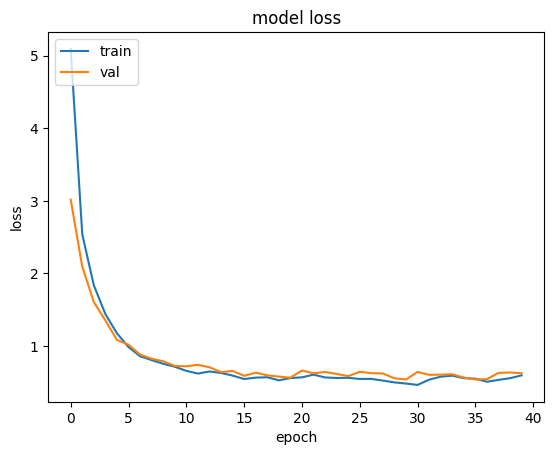

In [ ]:
v1,v2=history.history['accuracy'],history.history['val_accuracy']
def plot_graph(v1,v2,xlabel,ylabel,title):
    plt.plot(v1)
    plt.plot(v2)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
#     plt.legend(['train', 'val'], loc='upper left')
    plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
test_dir="/content/test"
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')


Found 240 images belonging to 7 classes.


In [ ]:
test_generator.class_indices

{'Motorcycle': 0,
 'bus': 1,
 'car': 2,
 'large_truck': 3,
 'microbus': 4,
 'semi_truck': 5,
 'truck': 6}

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)


8/8 [==============================] - 8s 987ms/step - loss: 0.5902 - accuracy: 0.9042
Test loss: 0.5901538729667664
Test accuracy: 0.9041666388511658


In [ ]:
model.save("car_classifier_resnet_version7.h5")

## Model 2

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers as L
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
IMG_SHAPE=(224,224)
classes=list(train_generator.class_indices.keys())
classes

['Motorcycle', 'bus', 'car', 'large_truck', 'microbus', 'semi_truck', 'truck']

In [ ]:
data_augmentation= Sequential(
[
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomWidth(0.1),
    preprocessing.RandomHeight(0.1),
    preprocessing.RandomFlip("horizontal")
],name='data-augmentiation-layer')


In [ ]:

model_e= EfficientNetB0(include_top=False)
model_e.trainable=False
input_layer= L.Input(shape=IMG_SHAPE+(3,),name='input_layer')
x= data_augmentation(input_layer)
x=model_e(x)
x=L.GlobalAveragePooling2D(name='minimazie_dimentions')(x)
x= L.Dense(128,activation='relu',name='added_layer_1')(x)
output_layer= L.Dense(len(classes),activation='softmax',name='output_layer')(x)
model= keras.Model(input_layer,output_layer)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data-augmentiation-layer (S  (None, None, None, 3)    0         
 equential)                                                      
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 minimazie_dimentions (Globa  (None, 1280)             0         
 lAveragePooling2D)                                              
                                                                 
 added_layer_1 (Dense)       (None, 128)               163968    
                                                                 
 output_layer (Dense)        (None, 7)                 903 

In [ ]:
for i in model.layers:
    print(i.name.ljust(25),i.trainable)

input_layer               True
data-augmentiation-layer  True
efficientnetb0            False
minimazie_dimentions      True
added_layer_1             True
output_layer              True


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=8)

checkpoint_path='callbacks/ModelCheckPoint/'
checkpoint= ModelCheckpoint(
            checkpoint_path,
            save_weights_only=True, # save only the model weights
            monitor="val_accuracy", # save the model weights which score the best validation accuracy
            save_best_only=True)
    

In [ ]:
history=model.fit(train_generator,
             epochs=10,
          validation_data=val_generator,
          callbacks=[
              checkpoint,
              early_stopping]
                 )

Epoch 1/10
51/51 [==============================] - 68s 1s/step - loss: 1.1906 - accuracy: 0.5498 - val_loss: 0.9035 - val_accuracy: 0.6739
Epoch 2/10
51/51 [==============================] - 60s 1s/step - loss: 0.7489 - accuracy: 0.7260 - val_loss: 0.7383 - val_accuracy: 0.7300
Epoch 3/10
51/51 [==============================] - 59s 1s/step - loss: 0.6303 - accuracy: 0.7807 - val_loss: 0.6696 - val_accuracy: 0.7862
Epoch 4/10
51/51 [==============================] - 58s 1s/step - loss: 0.5667 - accuracy: 0.7924 - val_loss: 0.6332 - val_accuracy: 0.7819
Epoch 5/10
51/51 [==============================] - 69s 1s/step - loss: 0.5250 - accuracy: 0.8071 - val_loss: 0.6289 - val_accuracy: 0.7862
Epoch 6/10
51/51 [==============================] - 68s 1s/step - loss: 0.4656 - accuracy: 0.8354 - val_loss: 0.6523 - val_accuracy: 0.7559
Epoch 7/10
51/51 [==============================] - 69s 1s/step - loss: 0.4309 - accuracy: 0.8452 - val_loss: 0.5660 - val_accuracy: 0.7991
Epoch 8/10
51/51 [==

In [ ]:
model.evaluate(test_generator)

8/8 [==============================] - 6s 676ms/step - loss: 0.5223 - accuracy: 0.8417


[0.5222560167312622, 0.8416666388511658]

In [ ]:
for layer in model_e.layers[len(model_e.layers)-11:]:
  layer.trainable = True

In [ ]:
for layer_number, layer in enumerate(model_e.layers):
  print(str(layer_number).ljust(3), layer.name.ljust(29), str(layer.trainable).ljust(5))

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [ ]:
history.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
tuned_history=model.fit(train_generator,epochs=35+len(history.epoch),
              initial_epoch=history.epoch[-1],
              validation_data=val_generator,)

Epoch 10/45
51/51 [==============================] - 69s 1s/step - loss: 0.4531 - accuracy: 0.8514 - val_loss: 0.5748 - val_accuracy: 0.7819
Epoch 11/45
51/51 [==============================] - 58s 1s/step - loss: 0.4153 - accuracy: 0.8722 - val_loss: 0.5783 - val_accuracy: 0.7840
Epoch 12/45
51/51 [==============================] - 58s 1s/step - loss: 0.3994 - accuracy: 0.8790 - val_loss: 0.5843 - val_accuracy: 0.7905
Epoch 13/45
51/51 [==============================] - 69s 1s/step - loss: 0.3547 - accuracy: 0.8931 - val_loss: 0.5863 - val_accuracy: 0.7840
Epoch 14/45
51/51 [==============================] - 68s 1s/step - loss: 0.3608 - accuracy: 0.8821 - val_loss: 0.5869 - val_accuracy: 0.7754
Epoch 15/45
51/51 [==============================] - 60s 1s/step - loss: 0.3349 - accuracy: 0.8919 - val_loss: 0.5867 - val_accuracy: 0.7819
Epoch 16/45
51/51 [==============================] - 58s 1s/step - loss: 0.3457 - accuracy: 0.8882 - val_loss: 0.5814 - val_accuracy: 0.7883
Epoch 17/45
5

In [ ]:
evaluated=model.evaluate(test_generator)

8/8 [==============================] - 6s 671ms/step - loss: 0.5277 - accuracy: 0.8417


In [ ]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

36
46
[0.8513513803482056, 0.872235894203186, 0.8789926171302795, 0.8931204080581665, 0.8820638656616211, 0.8918918967247009, 0.8882063627243042, 0.9041768908500671, 0.9054054021835327, 0.9066339135169983, 0.8992629051208496, 0.8906633853912354, 0.8937346339225769, 0.9164619445800781, 0.9078624248504639, 0.8992629051208496, 0.8949631452560425, 0.9060196280479431, 0.9146191477775574, 0.8949631452560425, 0.9189189076423645, 0.9115478992462158, 0.8949631452560425, 0.915847659111023, 0.9041768908500671, 0.8992629051208496, 0.9066339135169983, 0.8968058824539185, 0.89987713098526, 0.9041768908500671, 0.915847659111023, 0.9287469387054443, 0.9103193879127502, 0.921990156173706, 0.9213759303092957, 0.9256756901741028, 0.5497543215751648, 0.726044237613678, 0.7807125449180603, 0.7923833131790161, 0.8071253299713135, 0.8353808522224426, 0.8452088236808777, 0.8550368547439575, 0.8710073828697205, 0.8771498799324036]


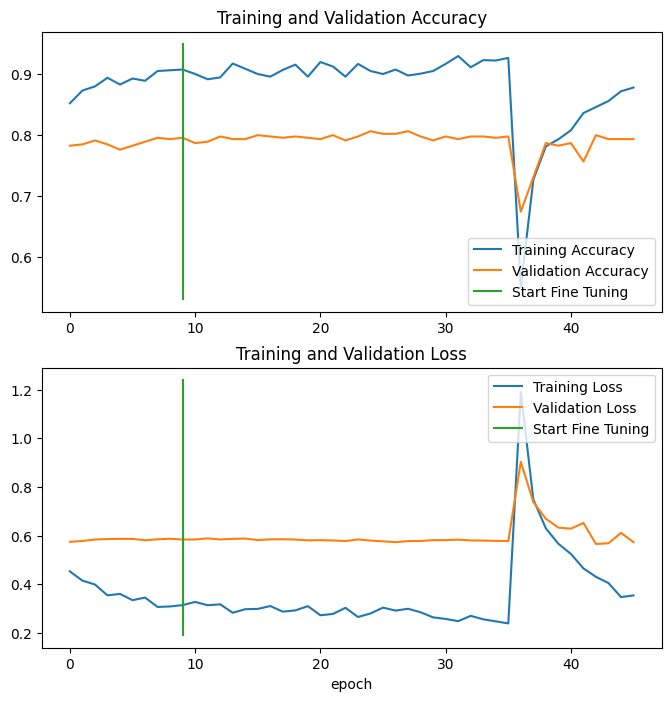

In [ ]:
compare_historys(tuned_history,history,10)